In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xarray as xr
import math as math
from scipy.optimize import curve_fit
import seaborn as sns
plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_10004\1272907536.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
dsm  = xr.open_dataset('eqcross_mv05iv06_r01_mti_2021.nc')
dsi  = xr.open_dataset('eqcross_mv05iv06_r01_ivm_2021 (1).nc')

dsi = dsi.load()

### Loading in Data

In [3]:
#CWW and PCA
dm0= dsm[['u','v', 'Ue1H','Ue1P','q']].sel(dt=slice(-45,45)).mean(dim= 'dt').isel(alt=slice(2,-2)) # Only u, v, Hall variables
di0 = dsi[['drift_mer','slt','dm_flag', 'rpa_flag']].sel(dt=slice(-45,45)).mean(dim = 'dt')# only use drift_mer variable (but also save other variables for context: local time, actual time, IVM data quality flags)
dt0 = dsi[['time']]

d_0 = xr.merge((dm0, di0, dt0))
d = d_0.dropna(dim='num', how='any', subset=['u','drift_mer','Ue1H','Ue1P']) # Drop missing data

# Only keep data where the ivm quality flag is good
d = d.where((d.slt > 11)  & (d.slt < 16) & (d.q.mean(dim='alt') > 0.95) & (d.dm_flag == 0) & (d.rpa_flag == 0), drop=True)

In [4]:
d

<xarray.Dataset>
Dimensions:    (num: 1398, alt: 80, dt: 961)
Coordinates:
  * alt        (alt) float64 94.28 97.21 100.1 103.1 ... 293.1 295.4 297.7 300.0
  * num        (num) int64 10 11 21 22 28 36 ... 7572 7576 7577 7582 7584 7586
  * dt         (dt) float64 -480.0 -479.0 -478.0 -477.0 ... 478.0 479.0 480.0
Data variables:
    u          (num, alt) float64 -68.29 -30.98 19.07 ... -9.639 -17.42 -25.18
    v          (num, alt) float64 88.07 117.0 89.5 24.04 ... 79.81 85.59 91.35
    Ue1H       (num) float64 7.855 -3.031 6.361 -0.6427 ... -47.54 -43.05 -20.58
    Ue1P       (num) float64 -21.39 -21.37 -18.78 ... -19.78 -0.1078 -9.584
    q          (num, alt) float64 1.0 1.0 1.0 1.0 ... 0.852 0.8935 0.9349 0.9762
    drift_mer  (num) float64 -1.021 -0.3412 2.802 -6.947 ... 22.22 26.88 25.06
    slt        (num) float32 15.88 15.69 15.85 15.91 ... 15.85 15.99 15.92 15.89
    dm_flag    (num) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    rpa_flag   (num) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    time       (num, dt) datetime64[ns] 2021-01-01T14:33:48.131000 ... 2021-1...

### PAIRS

In [5]:
# This will save all of the changes between the pairs.
delta_u = [] 
delta_v = []
delta_drift_mer = []
delta_uh = []
delta_up = []

for i in range(len(d.num)):
    # Status indicator
    if np.mod(i,50) == 0:
        print('%i / %i' % (i, len(d.num)))
    
    ds1 = d.isel(num=i)
    
    # Grab all other timestamps that are 24-24.15 hours in the future, collect them in dataset ds2
    delta_t = d.time - ds1.time 
    happens_soon_after = (delta_t > pd.to_timedelta('24h')) & (delta_t < pd.to_timedelta('24.15h'))
    ds2 = d.where(happens_soon_after, drop=True)
        
    # Record some parameters of interest.
    delta_u.extend(ds2.u - ds1.u)
    delta_v.extend(ds2.v-ds1.v)
    delta_drift_mer.extend(ds2.drift_mer - ds1.drift_mer)
    delta_uh.extend(ds2.Ue1H - ds1.Ue1H)
    delta_up.extend(ds2.Ue1P - ds1.Ue1P)
    

delta_u = np.array(delta_u)
delta_v = np.array(delta_v)
delta_drift_mer = np.array(delta_drift_mer)
delta_uh = np.array(delta_uh)
delta_up = np.array(delta_up)

0 / 1398
50 / 1398
100 / 1398
150 / 1398
200 / 1398
250 / 1398
300 / 1398
350 / 1398
400 / 1398
450 / 1398
500 / 1398
550 / 1398
600 / 1398
650 / 1398
700 / 1398
750 / 1398
800 / 1398
850 / 1398
900 / 1398
950 / 1398
1000 / 1398
1050 / 1398
1100 / 1398
1150 / 1398
1200 / 1398
1250 / 1398
1300 / 1398
1350 / 1398


In [6]:
df_u = pd.DataFrame(delta_u[:,:,0])
df_v = pd.DataFrame(delta_v[:,:,0])
df_drift_mer = pd.DataFrame(delta_drift_mer[:,0])
df_hall = pd.DataFrame(delta_uh[:,0])
df_peterson = pd.DataFrame(delta_up[:,0])

### Training

In [7]:
#CCW
df_CCW = pd.DataFrame()
df_CCW['Hall'] = df_hall[0]
df_CCW['Peterson'] = df_peterson[0]
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split

X_CCW = df_CCW
X_CCW.columns = X_CCW.columns.astype(str)
y_CCW = df_drift_mer

#Train Test Split
X_train_CCW, X_test_CCW, y_train_CCW, y_test_CCW = train_test_split(X_CCW, y_CCW, test_size=0.30,random_state = 42)

CCW_model = LinearRegression(fit_intercept=True)
CCW_model.fit(X_train_CCW, y_train_CCW)

d_hp = dsm[['ue1h_coef','ue1p_coef']].mean(dim = 'num').isel(alt=slice(2,-2))# Only Hall,Peterson variables
weight_CCW = d_hp.to_array()
d_HP= pd.DataFrame(weight_CCW)

y_train_pred_CCW = CCW_model.predict(X_train_CCW)
y_test_pred_CCW = CCW_model.predict(X_test_CCW)

from sklearn.metrics import r2_score
r2_train_sk_CCW = r2_score(y_train_CCW, y_train_pred_CCW)
r2_test_sk_CCW = r2_score(y_test_CCW, y_test_pred_CCW)

SP_CCW = d_HP.T.dot(CCW_model.coef_[0])
print(r2_train_sk_CCW,r2_test_sk_CCW)

0.21453904720179962 0.2306572609881854


In [10]:
#PCA w ZON 
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#df_X = df_u
#for i in range(0,80):
 #   df_X[79+i] = df_v[i]
    
    
X_PCA = df_u
y_PCA = df_drift_mer


#Train Test Split
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y_PCA, test_size=0.30,random_state = 42)

pca = PCA(n_components = 8)
pca.fit(X_train_PCA)

X_train_pca = pca.transform(X_train_PCA)
X_test_pca = pca.transform(X_test_PCA)

model_PCA = LinearRegression(fit_intercept=True)
model_PCA.fit(X_train_pca, y_train_PCA)

SP_PCA_u = pca.components_.T.dot(model_PCA.coef_[0])


y_train_pred_PCA = model_PCA.predict(X_train_pca)
y_test_pred_PCA = model_PCA.predict(X_test_pca)

from sklearn.metrics import r2_score
r2_train_sk_PCA = r2_score(y_train_PCA, y_train_pred_PCA)
r2_test_sk_PCA = r2_score(y_test_PCA, y_test_pred_PCA)
print(r2_train_sk_PCA,r2_test_sk_PCA)

0.2626618778105363 0.25646936323909153


In [8]:
#PCA w MER 
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#df_X = df_u
#for i in range(0,80):
 #   df_X[79+i] = df_v[i]
    
    
X_PCA = df_v
y_PCA = df_drift_mer


#Train Test Split
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y_PCA, test_size=0.30, random_state = 42)

pca = PCA(n_components = 8)
pca.fit(X_train_PCA)

X_train_pca = pca.transform(X_train_PCA)
X_test_pca = pca.transform(X_test_PCA)

model_PCA = LinearRegression(fit_intercept=True)
model_PCA.fit(X_train_pca, y_train_PCA)

SP_PCA_v = pca.components_.T.dot(model_PCA.coef_[0])


y_train_pred_PCA = model_PCA.predict(X_train_pca)
y_test_pred_PCA = model_PCA.predict(X_test_pca)

from sklearn.metrics import r2_score
r2_train_sk_PCA = r2_score(y_train_PCA, y_train_pred_PCA)
r2_test_sk_PCA = r2_score(y_test_PCA, y_test_pred_PCA)
print(r2_train_sk_PCA,r2_test_sk_PCA)

0.2398367472045081 0.15531277430521395


<IPython.core.display.Javascript object>


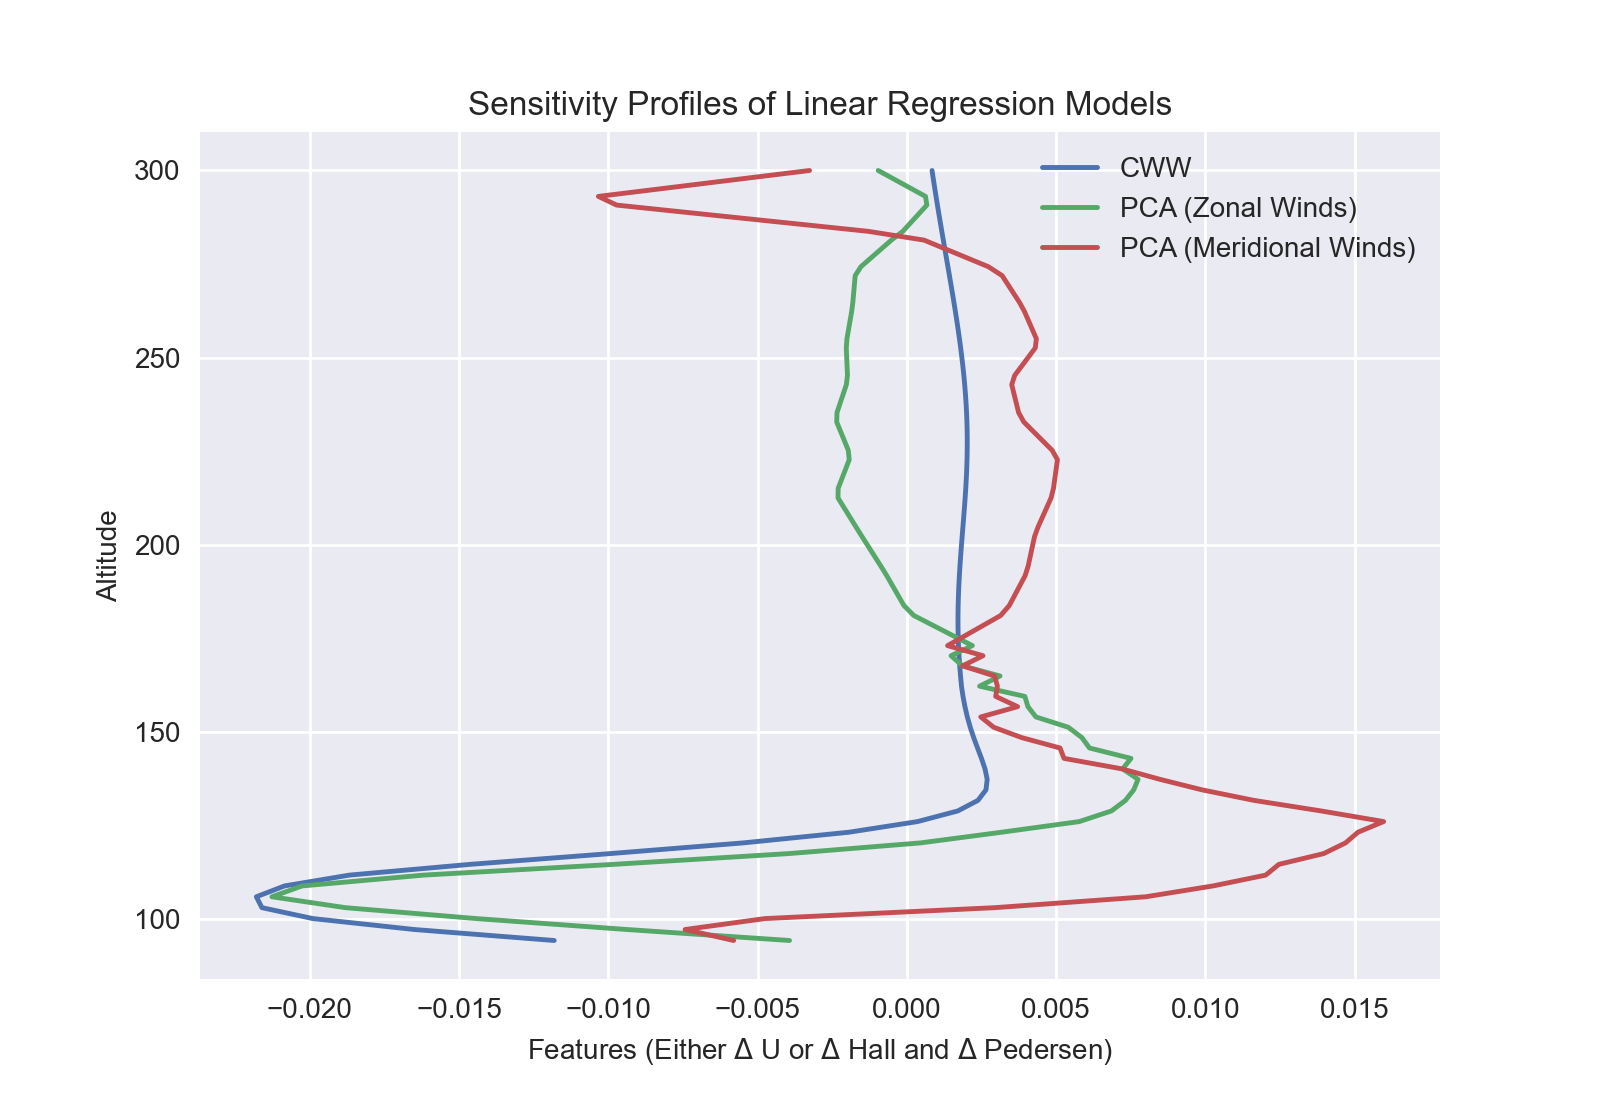

In [11]:
plt.figure()
plt.plot(SP_CCW,d.alt, label = 'CWW')
plt.plot(SP_PCA_u,d.alt, label = 'PCA (Zonal Winds)')
plt.plot(SP_PCA_v,d.alt, label = 'PCA (Meridional Winds)')
plt.title('Sensitivity Profiles of Linear Regression Models')
plt.ylabel('Altitude')
plt.xlabel('Features (Either $\Delta$ U or $\Delta$ Hall and $\Delta$ Pedersen)')
plt.legend()
plt.show()

### BOTH WINDS

In [12]:
#PCA w MER 
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_X = df_u
for i in range(0,80):
    df_X[79+i] = df_v[i]
    
    
X_PCA = df_X
y_PCA = df_drift_mer


#Train Test Split
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y_PCA, test_size=0.30, random_state = 42)

pca = PCA(n_components = 8)
pca.fit(X_train_PCA)

X_train_pca = pca.transform(X_train_PCA)
X_test_pca = pca.transform(X_test_PCA)

model_PCA = LinearRegression(fit_intercept=True)
model_PCA.fit(X_train_pca, y_train_PCA)

SP_PCA_winds = pca.components_.T.dot(model_PCA.coef_[0])


y_train_pred_PCA = model_PCA.predict(X_train_pca)
y_test_pred_PCA = model_PCA.predict(X_test_pca)

from sklearn.metrics import r2_score
r2_train_sk_PCA = r2_score(y_train_PCA, y_train_pred_PCA)
r2_test_sk_PCA = r2_score(y_test_PCA, y_test_pred_PCA)
print(r2_train_sk_PCA,r2_test_sk_PCA)

0.35379204270082265 0.29783045266366703


<IPython.core.display.Javascript object>


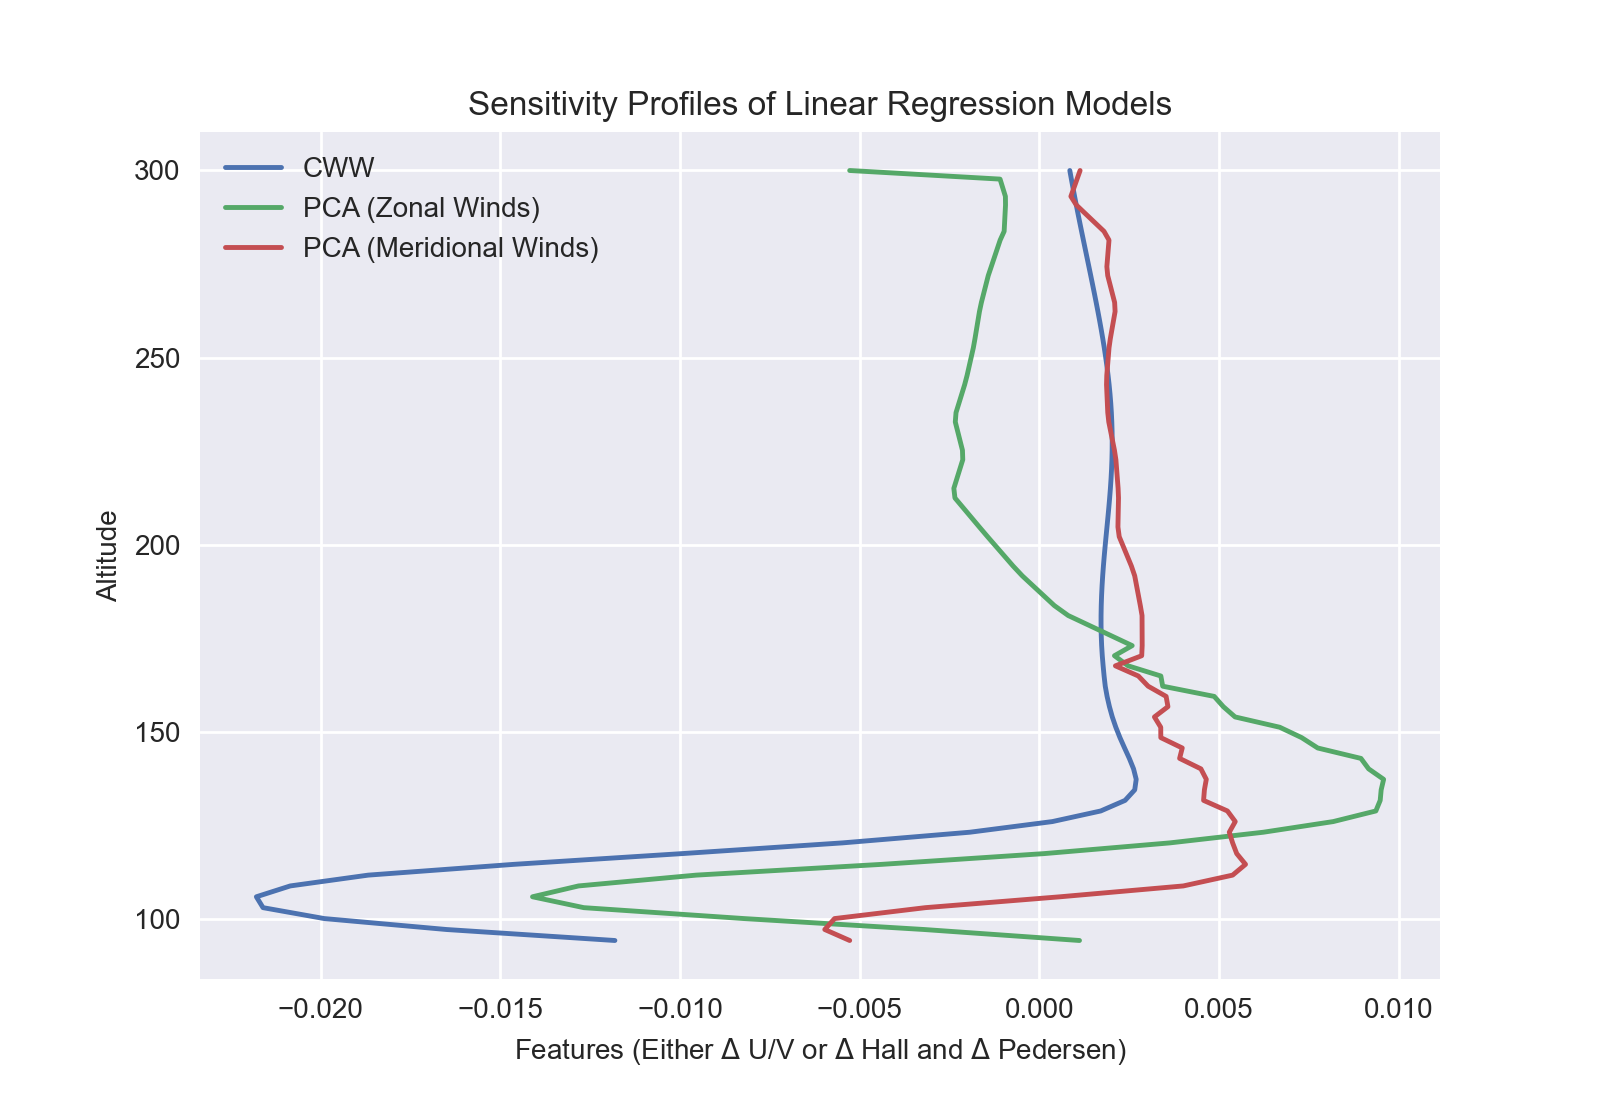

In [14]:
plt.figure()
plt.plot(SP_CCW,d.alt, label = 'CWW')
plt.plot(SP_PCA_winds[0:80],d.alt, label = 'PCA (Zonal Winds)')
plt.plot(SP_PCA_winds[79:160],d.alt, label = 'PCA (Meridional Winds)')
plt.title('Sensitivity Profiles of Linear Regression Models')
plt.ylabel('Altitude')
plt.xlabel('Features (Either $\Delta$ U/V or $\Delta$ Hall and $\Delta$ Pedersen)')
plt.legend()
plt.show()
plt.savefig('sensitivity_both_winds')